### Requirements

In [3]:
from functions.helping_functions import *
from functions.Financials import *

In [5]:
pip install geopy

  Using cached geopy-2.3.0-py3-none-any.whl (119 kB)
  Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install mapclassify

  Using cached mapclassify-2.5.0-py3-none-any.whl (39 kB)
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)



In [8]:
pip install geocoder

  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached ratelim-0.1.6-py2.py3-none-any.whl (4.0 kB)
  Using cached future-0.18.3-py3-none-any.whl


In [9]:
from shapely.geometry import Point
import os
import csv
import pyproj
import geopy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import folium
import geopandas as gpd
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.pipeline import make_pipeline
import mapclassify
from shapely.geometry import shape
import geocoder
import math
import datetime

In [ ]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [ ]:
df_routes = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\D-routes-2022.csv", on_bad_lines='skip', sep=';')
df_tmja = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\E-tmja-2019.csv", on_bad_lines='skip', sep=';')
df_station = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\I-Donne╠ües de stations TE_DV.xlsx - export_data_te.csv")

In [ ]:
df_routes = pd.DataFrame(df_routes)
df_tmja = pd.DataFrame(df_tmja)

#### TMJA

In [ ]:
def add_lat_lon_columns(df):
    """
    Adds new columns 'lonD', 'latD', 'lonF', 'latF' to the dataframe with
    corresponding latitude and longitude values based on the 'xD', 'yD', 'xF',
    and 'yF' columns, which are in Lambert-93 projection.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the columns 'xD', 'yD', 'xF', and 'yF'.

    Returns:
    --------
    pandas.DataFrame
        The original dataframe with the new 'lonD', 'latD', 'lonF', and 'latF'
        columns added.
    """
    # Define the input and output projections
    in_proj = pyproj.Proj(init='epsg:2154')  # Lambert-93
    out_proj = pyproj.Proj(init='epsg:4326')  # WGS84

    df['xD'] = df['xD'].str.replace(',', '.')
    df['yD'] = df['yD'].str.replace(',', '.')
    df['xF'] = df['xF'].str.replace(',', '.')
    df['yF'] = df['yF'].str.replace(',', '.')

    # Convert start coordinates to lat-long
    df['lonD'], df['latD'] = pyproj.transform(in_proj, out_proj, df['xD'], df['yD'])

    # Convert end coordinates to lat-long
    df['lonF'], df['latF'] = pyproj.transform(in_proj, out_proj, df['xF'], df['yF'])

    return df

### Stations Analysis

In [ ]:
def remove_dom_tom(df:pd.DataFrame)-> pd.DataFrame:
    '''
    Removes idenfied Dom Tom data from our database
    '''
    mask = df["Adresse"].str.contains("GUYANNE|REUNION|MARTINIQUE|GUADELOUPE|FORT DE FRANCE| LA SALLE LES ALPES")
    df = df[~mask]
    return df

In [ ]:
df_station = remove_dom_tom(df_station)

In [ ]:
# Remove DOM TOM``
mask = df_station["Adresse"].str.contains("GUYANNE|REUNION|MARTINIQUE|GUADELOUPE|FORT DE FRANCE| LA SALLE LES ALPES")
df_station = df_station[~mask]

In [ ]:
print(df_station['Adresse'].str.contains("Guyane").sum())
print(df_station['Adresse'].str.contains("Reunion").sum())

In [ ]:
df_station['Coordinates'] = df_station['Coordinates'].apply(lambda x: x.replace(',,', ','))

In [ ]:
df_station['Coordinates'].apply(lambda x: x.split(',')[1]).min()

In [ ]:
def add_lat_long(df:pd.DataFrame)-> pd.DataFrame:
    '''
    Add Longitude and Latitude columns based on Coordiantes columnb
    '''
    df_station['latitude'] = df_station['Coordinates'].apply(lambda x: x.split(',')[0]).astype(float)
    df_station['longitude'] =df_station['Coordinates'].apply(lambda x: x.split(',')[1]).astype(float)
    return df_station

In [ ]:
df_station = add_lat_long(df_station)

In [ ]:
df_station['geometry'] = gpd.points_from_xy(x=df_station.Coordinates.apply(lambda x: float(x.split(',')[0])), 
                                          y=df_station.Coordinates.apply(lambda x: float(x.split(',')[1])))

In [ ]:
shp_stations = gpd.GeoDataFrame(df_station, geometry='geometry')
shp_stations = shp_stations.set_crs('epsg:2154', allow_override=True)
shp_stations.explore(tiles="OpenStreetMap")

### Logistic Hubs

In [ ]:
# import data
df_Logistic = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\Donne_Logistique\Donnee_Logistique.csv")
df_Logistic_regional = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\Donne_Logistique\Donnee_regionale.csv")
Logistic_shape = gpd.read_file(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\F-aire-logistiques-donnees-detaillees\Aires_logistiques_denses.shp")

In [ ]:
df_Logistic = df_Logistic.rename(columns ={'Identifiant aire logistique dense (e1)':'e1'})
df_Logistic['e1'].nunique()

In [ ]:
df_Logistic = df_Logistic.merge(Logistic_shape,on='e1')
df_Logistic

In [ ]:
df_Logistic.iloc[:,4].apply(lambda x: datetime.datetime.strptime(x, '%b-%y').strftime('%m-%y'))

In [ ]:
#df_Logistic.head()

In [ ]:
address = df_Logistic['Communes concernées par l\'aire logistique'][0]
g = geocoder.arcgis(address,country = 'France')
lat, lng = g.latlng
print("Latitude: ", lat)
print("Longitude:", lng)

In [ ]:
Logistic_shape

In [ ]:
# Too many towns make the geolocalization algorithm crash
df_Logistic['Communes concernées par l\'aire logistique'][290] = 'Genneviliers'
df_Logistic['Communes concernées par l\'aire logistique'][290]

In [ ]:
def geocode_address(df):
    for index, address in df['Communes concernées par l\'aire logistique'].items():
        #print(index)
        g = geocoder.arcgis(address, country="France")
        df.loc[index,'longitude'] = g.latlng[0]
        df.loc[index,'latitude'] = g.latlng[1]
        
    return df

In [ ]:
geocode_address(df_Logistic)

In [ ]:
gdf_Logistic.head(2)

,e1,Région d'implantation,Numéro aires dans région,Communes concernées par l'aire logistique,Nombre d'EPL de plus de 5 000 m2,Surface totale,P_Transport_et_entreposage,P_commerce,P_industrie,P_autres,Eff_com_entreposage,EFF_EPL_5000,Poids de l'entreposage,Chargement,Déchargement,geometry,longitude,latitude
0,1,52,3,"Saint-Nazaire, Montoir-de-Bretagne, Trignac",Oct-19,155000,0.600000,0.100000,0.3,0.0,1800,300,0.045252971,30,30,"POLYGON ((306902.300 6698606.120, 306928.370 6...",47.32833,-2.14917
1,11,52,19,Saint-Sylvain-d'Anjou,03-Sep,50000,0.333333,0.666667,0.0,0.0,NC,NC,NC,NC,NC,"POLYGON ((438799.329 6718105.186, 437358.871 6...",47.51942,-0.47204


In [ ]:
gdf_Logistic = gpd.GeoDataFrame(df_Logistic, crs="EPSG:4326", geometry='geometry')
gdf_Logistic = gdf_Logistic.set_crs('epsg:2154', allow_override=True)

In [ ]:
gdf_Logistic.explore()

In [ ]:
df_routes.head(2)

,Identifiant aire logistique dense (e1),Région d'implantation,Numéro aires dans région,Communes concernées par l'aire logistique,Nombre d'EPL de plus de 5 000 m2,Surface totale,P_Transport_et_entreposage,P_commerce,P_industrie,P_autres,Eff_com_entreposage,EFF_EPL_5000,Poids de l'entreposage,Chargement,Déchargement
0,1,52,3,"Saint-Nazaire, Montoir-de-Bretagne, Trignac",Oct-19,155000,0.600000,0.100000,0.3,0.0,1800,300,0.045252971,30,30
1,11,52,19,Saint-Sylvain-d'Anjou,03-Sep,50000,0.333333,0.666667,0.0,0.0,NC,NC,NC,NC,NC


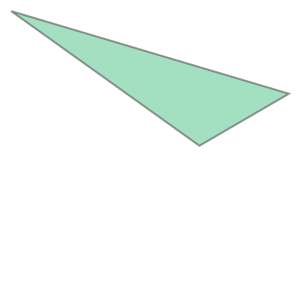

In [ ]:
gdf_Logistic['geometry'][1].geometry.contains()

In [ ]:
#ax = gdf_Logistic.plot(figsize=(10,10), alpha=0.5, edgecolor='k')
#gdf_Logistic.explore()


In [ ]:
Logistic['geometry'][1]

Strategy :
Limit the model to 3 region
Create scoring system based on multiple criterias. Scoring system is an f(x,y) function with x lat, y long. Constraints are not yet to be defined but include distance to logistic hub, traffic on road, pop dens,..




### Financials

In [10]:
station_info = {
    'station_type': ['small', 'medium', 'large'],
    'capex': [3, 5, 8],
    'depreciation': [0.15,0.15,0.15],
    'opex': [0.1 * 3, 0.08 * 5, 0.07 * 8],
    'storage': [2, 3, 4],
    'construction_time': [1, 1, 1],
    'footprint': [650, 900, 1200],
    'prof_threshold': [0.9, 0.8, 0.6]
}

df_station_info = pd.DataFrame(station_info).reset_index(drop=True)

In [11]:
df_station_info['yearly_depreciation'] = df_station_info['capex'] * df_station_info ['depreciation']

In [12]:
results = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\chosen_stations_2030.csv")

In [13]:
results.head(2)

,Unnamed: 0,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,TMJA_PL,percentage_traffic,Quantity_sold_per_day(in kg),Revenues_day,Quantity_sold_per_year(in kg),not_prof,small_station,medium_station,large_station,station_type
0,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,88524.21,0.007146,610.150730,4271.055110,222705.016468,0,0,0,1,large
1,2259,2259,678803.525886,6.772659e+06,A0019,POINT (678803.525886168 6772658.721447919),1.0,0 3789.727742\ndtype: float64,5.0,0 3303.402529\ndtype: float64,26815.98,0.002165,343.252778,2402.769446,125287.263995,0,0,0,1,large


In [14]:
results['station_type'].value_counts()

large             357
not profitable     19
Name: station_type, dtype: int64

In [24]:
df_station_info.dtypes

station_type            object
capex                    int64
depreciation           float64
opex                   float64
storage                  int64
construction_time        int64
footprint                int64
prof_threshold         float64
yearly_depreciation    float64
threshold              float64
dtype: object

In [32]:
fin = financials(results, df_station_info,2030)
#fin

In [30]:
depl_2030 = deployment_dates(results,2023,2030)
depl_2030

,Unnamed: 0,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,...,small_station,medium_station,large_station,station_type,Revenues,EBITDA,Opex,EBIT,depreciation,date_installation
0,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,1,large,1.558935e+06,9.989351e+05,560000.0,3.589351e+05,-640000.0,2028
1,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,1,large,1.558935e+06,9.989351e+05,560000.0,3.589351e+05,-640000.0,2028
2,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,1,large,1.558935e+06,9.989351e+05,560000.0,3.589351e+05,-640000.0,2028
3,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,1,large,1.558935e+06,9.989351e+05,560000.0,3.589351e+05,-640000.0,2028
4,2259,2259,678803.525886,6.772659e+06,A0019,POINT (678803.525886168 6772658.721447919),1.0,0 3789.727742\ndtype: float64,5.0,0 3303.402529\ndtype: float64,...,0,0,1,large,8.770108e+05,3.170108e+05,560000.0,-3.229892e+05,-640000.0,2030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,385,385,807203.184114,6.882408e+06,A0004,POINT (807203.1841144717 6882408.230964924),1.0,0 9581.042312\ndtype: float64,5.0,0 8376.801061\ndtype: float64,...,0,0,1,large,2.871703e+06,2.311703e+06,560000.0,1.671703e+06,-640000.0,2023
434,1277,1277,801336.755906,6.295823e+06,A0009,POINT (801336.7559063311 6295822.9268937),1.0,0 7460.057724\ndtype: float64,5.0,0 434.456798\ndtype: float64,...,0,0,1,large,2.894629e+06,2.334629e+06,560000.0,1.694629e+06,-640000.0,2023
435,1598,1598,428460.872784,6.567394e+06,A0010,POINT (428460.8727839426 6567394.1712706825),1.0,0 17473.525383\ndtype: float64,5.0,0 12737.324739\ndtype: float64,...,0,0,1,large,1.942886e+06,1.382886e+06,560000.0,7.428859e+05,-640000.0,2027
436,1894,1894,610015.896027,6.874528e+06,A0013,POINT (610015.8960266111 6874528.405782959),1.0,0 1884.753642\ndtype: float64,5.0,0 586.327276\ndtype: float64,...,0,0,1,large,2.176175e+06,1.616175e+06,560000.0,9.761751e+05,-640000.0,2026
